# Spectral Derivatives with Arbitrary Domains

The standard Fourier-based spectral method assumes the function is both periodic and sampled on $[0, 2\pi)$, and the standard Chebyshev-based method assumes the function is sampled at cosine-spaced points on $[1, -1]$. But what if we want to find the derivatives of a function on a different domain?

In principle we can scale and shift to the canonical domain, use one of the methods, and scale and shift back. But the details of doing this are tricky, so I've extended the code and [documentation](https://pavelkomarov.com/spectral-derivatives/specderiv.html) to help users work with arbitrary domains. Let's talk about it.

In [1]:
import sys; sys.path.append('../specderiv') # so I can import specderiv code from a neighboring working directory
from specderiv import cheb_deriv, fourier_deriv
import numpy as np
from matplotlib import pyplot

## Chebyshev

As an example, let's use our same $e^t \sin(5t)$ as [before](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/chebyshev.ipynb), but this time take its derivative on the interval $[1, 4]$.

To convert between domains we use:

$$x \in [1, -1] \leftrightarrow t \in [a,b] = [1, -1] \cdot \frac{b - a}{2} + \frac{b + a}{2}$$
$$x_n \in \cos(\frac{\pi [0, N]}{N}) \leftrightarrow t_n \in \cos(\frac{\pi [0, N]}{N}) \cdot \frac{b - a}{2} + \frac{b + a}{2} $$

You absolutely must use a $t_n$ of this form, otherwise the function won't work. I've added a check in the code and raise an error message if a user goofs this up.

In [2]:
N = 20
a = 1
b = 4

t_n = np.cos(np.arange(N+1) * np.pi / N) * (b - a)/2 + (b + a)/2 # Sample the function at t_n
t = np.linspace(a, b, 100) # A denser set of points over the domain, for plotting

If we now sample our function at these $t_n$, it's as if we've smooshed it in to the $[-1, 1]$ domain. Try it for yourself to get an intuition! Put these two in to [Desmos](https://www.desmos.com/calculator):

```
e^{x}\sin(5x)\left\{1\le x\le4\right\}
e^{(\frac{3}{2}x\ +\ \frac{5}{2})}\sin(5\ (\frac{3}{2}x+\frac{5}{2}))\ \left\{-1\le x\le1\right\}
```

We can then use the standard spectral method to find the derivative of the shifted-and-smooshed function on $[1, -1]$, which will be the same as the derivative of the original function, modulo the smoosh: Notice everything has become more or less steep depending on the relative length of the interval $[a, b]$ versus $[1,-1]$. This will scale the derivative by exactly $\frac{b - a}{2}$, and it will scale higher-order derivatives by exactly $\big( \frac{b - a}{2} \big)^\nu$. The code programmatically calculates this factor and scales the answer accordingly.

/usr/local/lib/python3.13/site-packages/specderiv/specderiv.py:97: UserWarning: endpoints set to NaN, only calculated for 4th derivatives and below
  warn("endpoints set to NaN, only calculated for 4th derivatives and below")


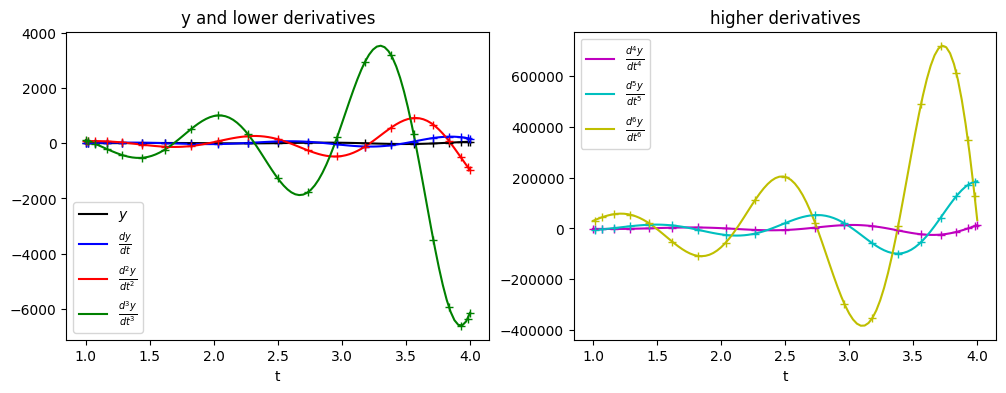

In [3]:
# You can evaluate these with WolframAlpha or by hand.
y = np.exp(t) * np.sin(5*t)
dy = 5*np.exp(t) * np.cos(5*t) + y
d2y = 2*np.exp(t) * (5*np.cos(5*t) - 12*np.sin(5*t))
d3y = -2*np.exp(t) * (37*np.sin(5*t) + 55*np.cos(5*t))
d4y = 4*np.exp(t) * (119*np.sin(5*t) - 120*np.cos(5*t))
d5y = 4*np.exp(t) * (719*np.sin(5*t) + 475*np.cos(5*t))
d6y = 8*np.exp(t) * (2035*np.cos(5*t) - 828*np.sin(5*t))

fig, axes = pyplot.subplots(1, 2, figsize=(12,4))
axes[0].plot(t, y, 'k', label="$y$")
axes[0].plot(t, dy, 'b', label=r"$\frac{dy}{dt}$")
axes[0].plot(t, d2y, 'r', label=r"$\frac{d^2y}{dt^2}$")
axes[0].plot(t, d3y, 'g', label=r"$\frac{d^3y}{dt^3}$")
axes[0].set_title("y and lower derivatives")
axes[0].set_xlabel('t')
axes[0].legend()
axes[1].plot(t, d4y, 'm', label=r"$\frac{d^4y}{dt^4}$")
axes[1].plot(t, d5y, 'c', label=r"$\frac{d^5y}{dt^5}$")
axes[1].plot(t, d6y, 'y', label=r"$\frac{d^6y}{dt^6}$")
axes[1].set_title("higher derivatives")
axes[1].set_xlabel('t')
axes[1].legend()

# x = cos -> t = cos * (t_N - t_0)/2 + (t_N + t_0)/2
y_n = np.exp(t_n) * np.sin(5*t_n)
dy_n = cheb_deriv(y_n, t_n, 1)
d2y_n = cheb_deriv(y_n, t_n, 2)
d3y_n = cheb_deriv(y_n, t_n, 3)
d4y_n = cheb_deriv(y_n, t_n, 4)
d5y_n = cheb_deriv(y_n, t_n, 5)
d6y_n = cheb_deriv(y_n, t_n, 6)

axes[0].plot(t_n, y_n, 'k+')
axes[0].plot(t_n, dy_n, 'b+')
axes[0].plot(t_n, d2y_n, 'r+')
axes[0].plot(t_n, d3y_n, 'g+')
axes[1].plot(t_n, d4y_n, 'm+')
axes[1].plot(t_n, d5y_n, 'c+')
axes[1].plot(t_n, d6y_n, 'y+');

## Fourier

Let's use something similar to $\cos(\theta) + 2\sin(3\theta))$ as [before](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/fourier.ipynb), this time adding a frequency factor, so it's no longer periodic on $[0, 2\pi)$:

$$ \cos(\frac{\pi}{2} t) + 2\sin(\frac{3\pi}{2} t)),\quad t \in [4, 8)$$

Convince yourself this is periodic in the [graphing calculator](https://www.desmos.com/calculator) again:

```
\cos(\frac{\pi}{2}x)\ +\ 2\sin(\frac{3\pi}{2}x)\ \left\{4\le x<8\right\}
```

To get us back to $\theta$ so we can use the spectral method, we convert with

$$\theta \in [0, 2\pi) \leftrightarrow t \in [a, b) = [0, 2\pi) \cdot \frac{b - a}{2\pi} + a$$
$$ \theta_n \in \frac{[0, M) \cdot 2\pi}{M} \leftrightarrow t_n \in \frac{[0, M) \cdot \cancel{2\pi}}{M} \cdot \frac{b - a}{\cancel{2\pi}} + a$$

In [6]:
M = 20 # length M, in keeping with the usage of M in my math.pdf notes.
a = 4
b = 8

t_n = np.arange(0, M)/M * (b - a) + a # It's important this be an *open* periodic domain, or we get artefacting
t = np.linspace(a, b, 100) # A denser set of points over the domain, for plotting

We can now sample the function at $t_n$, which is as if we've smooshed it in to $[0, 2\pi)$.

[Convince yourself this is true](https://www.desmos.com/calculator):
```
\cos(\frac{\pi}{2}(x\frac{2}{\pi}+4))\ +\ 2\sin(\frac{3\pi}{2}(x\frac{2}{\pi}+4))\ \left\{0\le x<2\pi\right\}
```

We can then use the standard spectral method to find the derivative of the shifted-and-smooshed function on $[0, 2\pi)$, which will be the same as the derivative of the original function, modulo the smoosh: Notice everything has become more or less steep depending on the relative length of the interval $[a, b)$ versus $[0,2\pi)$. This will scale the derivative by exactly $\frac{b - a}{2\pi}$, and it will scale higher-order derivatives by exactly $\big( \frac{b - a}{2\pi} \big)^\nu$. The code programmatically calculates this factor and scales the answer accordingly.

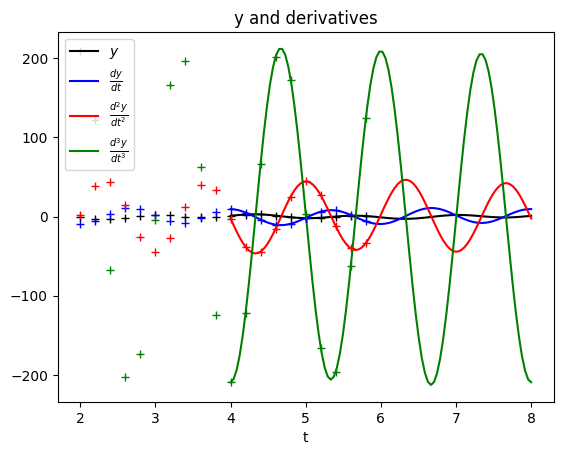

In [7]:
# true function and analytic derivatives. You can evaluate these with WolframAlpha or by hand.
y = np.cos(np.pi/2 * t) + 2*np.sin(3*np.pi/2 * t)
dy = 3*np.pi*np.cos(3*np.pi/2 * t) - np.pi/2 * np.sin(np.pi/2 * t) 
d2y = -(np.pi**2)/4 * np.cos(np.pi/2 * t) - (9*np.pi**2)/2 * np.sin(3*np.pi/2 * t)
d3y = (np.pi**3)/8 * np.sin(np.pi/2 * t) - (27*np.pi**3)/4 * np.cos(3*np.pi/2 * t)

pyplot.plot(t, y, 'k', label="$y$")
pyplot.plot(t, dy, 'b', label=r"$\frac{dy}{dt}$")
pyplot.plot(t, d2y, 'r', label=r"$\frac{d^2y}{dt^2}$")
pyplot.plot(t, d3y, 'g', label=r"$\frac{d^3y}{dt^3}$")
pyplot.title("y and derivatives")
pyplot.xlabel('t')
pyplot.legend()

# sampled function and computed derivatives
y_n = np.cos(np.pi/2 * t_n) + 2*np.sin(3*np.pi/2 * t_n)
dy_n = fourier_deriv(y_n, t_n, 1)
d2y_n = fourier_deriv(y_n, t_n, 2)
d3y_n = fourier_deriv(y_n, t_n, 3)

pyplot.plot(t_n, y_n, 'k+')
pyplot.plot(t_n, dy_n, 'b+')
pyplot.plot(t_n, d2y_n, 'r+')
pyplot.plot(t_n, d3y_n, 'g+');